# Работу выполнили 
Студенты группы 4230М А.Н. Секунов, Д.А. Фомин.

# Задание
Дан многомерный размеченный набор данных, для которого был выполнен 
разведочный и предиктивный анализ в ЛР1. Необходимо выполнить предиктивный 
анализ данных на основе регрессионных моделей по вариантам. Анализ выполняется 
для исходного набора данных, преобразованного набора исходного данных, 
построенного в ЛР1 набора данных и преобразованного построенного в ЛР1 набора 
данных.  

Предиктивный анализ выполняется с помощью неансамблевой и ансамблевой
модели по варианту. Результаты сравниваются и выбирается лучший вариант по 
модели и анализируемому набору данных.   

Для выбранной комбинации набора данных и предиктивной модели 
выполняется поиск гиперпараметра на обучающем и тестовом наборах.
Полученный результат сравнивается с результатом наилучшей предиктивной 
модели/набора, найденными в ЛР1.  

Сделать выводы по проведенному анализу.

# Исходные данные

Вариант 2.

Набор данных цен на недвижимость. Построить регрессионную модель для целевого признака «Y house price of unit area» (цена объекта недвижимости) от
остальных входных признаков.

- Модель CART
- Random Forest

# Выполнение работы

## Загрузка используемых пакетов библиотек

In [1]:
import os
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.options.mode.chained_assignment = None

## Загрузка исходных данных

In [2]:
HOUSING_URL = 'https://github.com/Demetrey/DMaP/blob/master/LR1/datasets/LR1_datasets.tar.gz?raw=true'
HOUSING_PATH = os.path.join('datasets', 'housing')

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'LR1_datasets.tar.gz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
HOUSING_FILENAME = os.path.join(HOUSING_PATH, 'V2.csv')
housing = pd.read_csv(HOUSING_FILENAME)
cols = housing.columns
# удаление столбцов индексов и столбца X2, убранного в ходе очистки данных (ЛР1)
housing.drop([cols[0], cols[1], cols[3]], axis=1, inplace=True)

In [6]:
housing.head()

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,84.87882,10,24.98298,121.54024,37.9
1,2012.917,306.59470,9,24.98034,121.53951,42.2
2,2013.583,561.98450,5,24.98746,121.54391,47.3
3,2013.500,561.98450,5,24.98746,121.54391,54.8
4,2012.833,390.56840,5,24.97937,121.54245,43.1


In [7]:
housing.describe()

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,6488.021000,10.000000,25.014590,121.566270,117.500000


## Выделение наборов данных

In [8]:
Ycorr = housing.corr()[housing.columns[-1]]
Kbest = SelectKBest(k=5).fit(housing.iloc[:, :5], housing.iloc[:, 5]).scores_
pd.DataFrame({'Ycorr': Ycorr, 'Kbest': Kbest}, index=housing.columns[:5])

,Ycorr,Kbest
X1 transaction date,0.087491,0.993150
X3 distance to the nearest MRT station,-0.673613,4.792860
X4 number of convenience stores,0.571005,2.010420
X5 latitude,0.546307,2.353937
X6 longitude,0.523287,1.903160


В ходе ЛР1 столбец X2 был удален в процессе очистки данных.  
На основе данных коэффициентов корреляции и метода SelectKBest сформированы 3 набора:
- first - исходные данные (X1, X3-X6)
- second - cущественные признаки (X3-X6)
- third - наиболее информативный признак (X3)

In [9]:
def split_data(data):
    cols = data.columns
    first_X = pd.DataFrame(data.iloc[:, :5], columns=cols[:5])
    second_X = first_X.drop(cols[0], axis=1)        # Удалили X1
    third_X = pd.DataFrame(first_X.loc[:, cols[1]]) # Извлекли X3
    data_Y = pd.DataFrame({cols[5]:data.iloc[:, 5]})     # Извлекли Y
    return first_X, second_X, third_X, data_Y

In [10]:
first_housing_X, second_housing_X, third_housing_X, housing_Y = split_data(housing)

## Стандартизация

In [11]:
scaler = StandardScaler().fit(housing)
s_housing = pd.DataFrame(scaler.fit_transform(housing), columns=housing.columns)
s_first_housing_X, s_second_housing_X, s_third_housing_X, s_housing_Y = split_data(s_housing)

## Выделение обучающей и тестовой выборки  
Выделим тестовую выборку как 20% от исходной, остальные 80% составят обучающую вуборку.
Исползуем заданное начальное значение для параметра ```random_state```, чтобы получать одни и те же обучающию и тестовую выборки при повторном запуске.

In [12]:
validation_size = 0.2
seed = 7
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(first_housing_X,  housing_Y, test_size=validation_size, random_state=seed)
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(second_housing_X, housing_Y, test_size=validation_size, random_state=seed)
X_train_t, X_test_t, Y_train_t, Y_test_t = train_test_split(third_housing_X,  housing_Y, test_size=validation_size, random_state=seed)
X_train_sf, X_test_sf, Y_train_sf, Y_test_sf = train_test_split(s_first_housing_X,  s_housing_Y, test_size=validation_size, random_state=seed)
X_train_ss, X_test_ss, Y_train_ss, Y_test_ss = train_test_split(s_second_housing_X, s_housing_Y, test_size=validation_size, random_state=seed)
X_train_st, X_test_st, Y_train_st, Y_test_st = train_test_split(s_third_housing_X,  s_housing_Y, test_size=validation_size, random_state=seed)

## Запуск моделей на обучающих данных

In [13]:
# Для хранения оценок по моделям
model_quality = pd.DataFrame(columns=['RMSE', 'R^2'])
# Модель CART
CART_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=25)
# Random Forest
RF_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=25)

In [14]:
def evaluate_model(name, model, X_train, Y_train, X_test=None, Y_test=None, rows=1, cols=1, is_show_info=True):
    if X_test is None: X_test = X_train
    if Y_test is None: Y_test = Y_train
    # Построение модели
    model.fit(X_train, Y_train.values.ravel())
    Y_pred = model.predict(X_test)
    # Расчёт критериев качества
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    model_quality.loc[name] = [rmse, r2]
    # Печать информании
    if is_show_info:
        print(f'RMSE for {name}: {rmse}')
        print(f'R^2 for {name}: {r2}')
        # Вывод графиков
        f = plt.figure(figsize=(6 * cols, 4 * rows))
        for i, x_name in enumerate(X_test):
            ax = f.add_subplot(rows, cols, i + 1)
            x = X_test[x_name]
            sort_xy = pd.DataFrame({'X': x, 'Y': Y_pred})
            sort_xy.sort_values(by='X', inplace=True)
            ax.plot(x, Y_test, 'o', alpha=0.3)
            ax.plot(x, Y_pred, 'o', alpha=0.5)
            ax.plot(sort_xy.X, sort_xy.Y, "r-")
            ax.set_xlabel(x_name)
            ax.set_ylabel('Y_pred for ' + name)

#### Модель CART_f - нестандартизованный исходный набор (X1, X3-X6)

RMSE for CART_f: 7.486764476241403
R^2 for CART_f: 0.7227443015173595


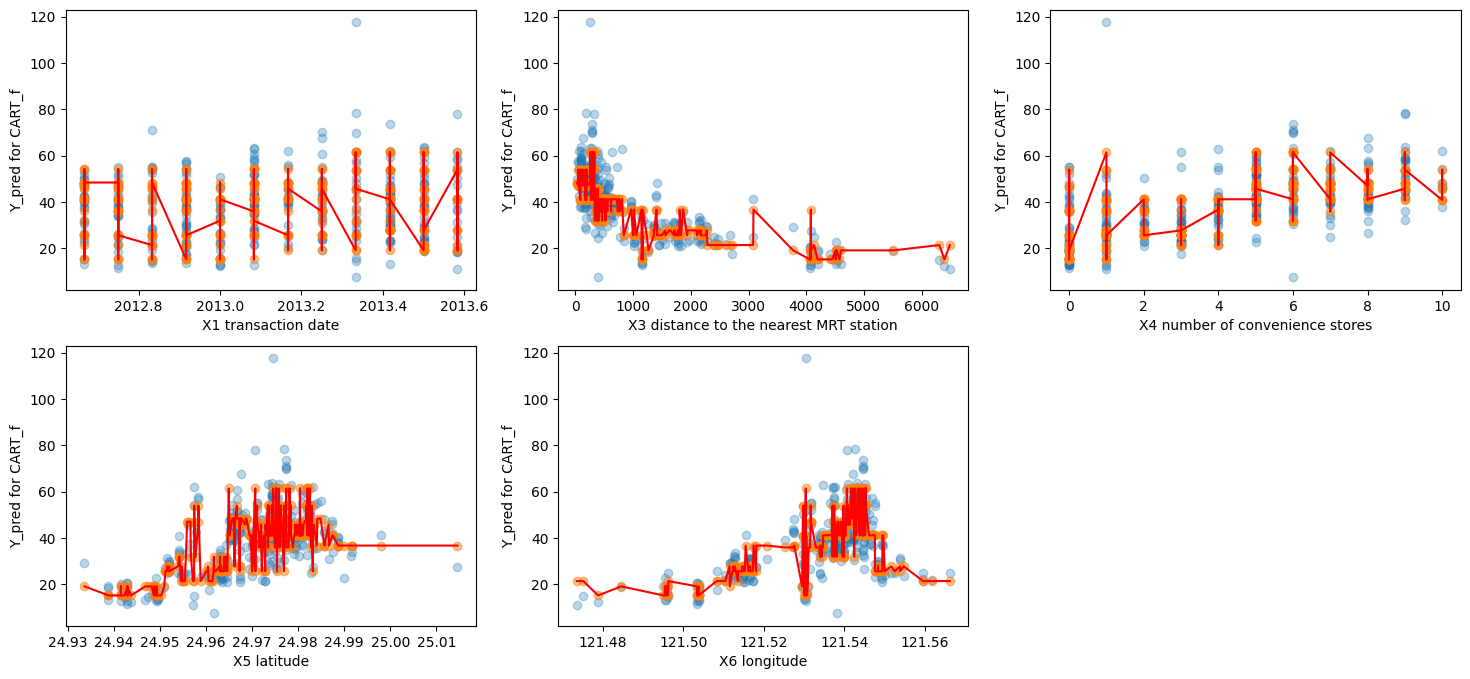

In [15]:
evaluate_model('CART_f', CART_model, X_train_f, Y_train_f, rows=2, cols=3)

#### Модель CART_sf - стандартизованный исходный набор (X1, X3-X6)

RMSE for CART_sf: 0.5509006469775947
R^2 for CART_sf: 0.7227443015173595


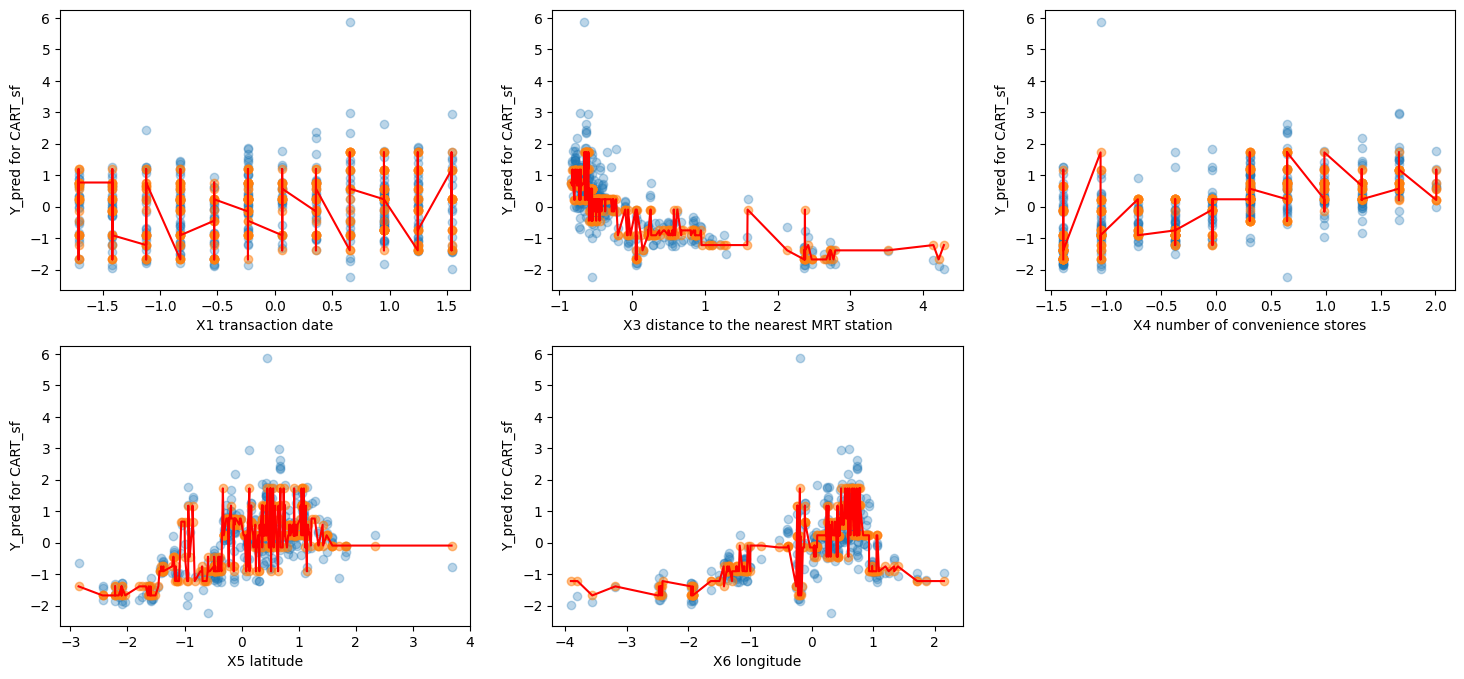

In [16]:
evaluate_model('CART_sf', CART_model, X_train_sf, Y_train_sf, rows=2, cols=3)

#### Модель RF_f (Random Forest) - нестандартизованный исходный набор (X1, X3-X6)

RMSE for RF_f: 7.277805899168985
R^2 for RF_f: 0.7380049558560722


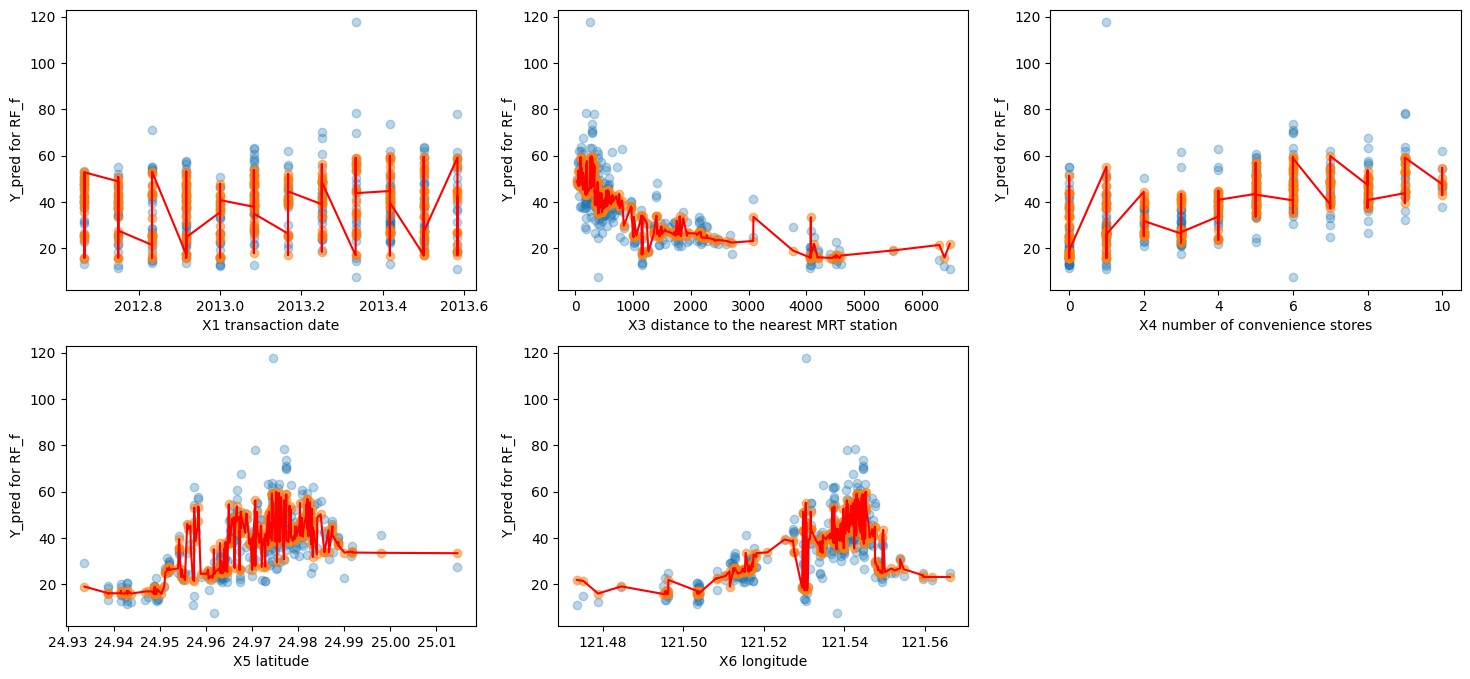

In [17]:
evaluate_model('RF_f', RF_model, X_train_f, Y_train_f, rows=2, cols=3)

#### Модель RF_sf (Random Forest) - стандартизованный исходный набор (X1, X3-X6)

RMSE for RF_sf: 0.53554264781757
R^2 for RF_sf: 0.73798748297739


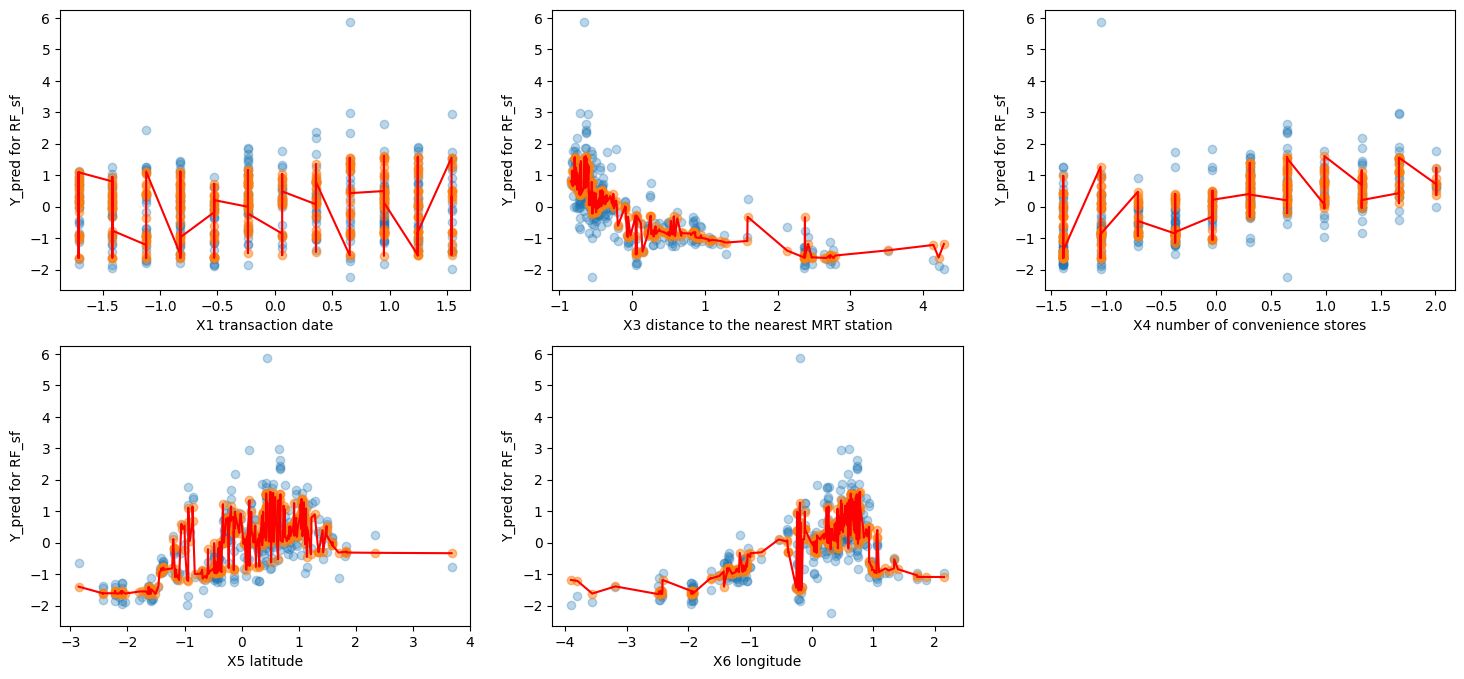

In [18]:
evaluate_model('RF_sf', RF_model, X_train_sf, Y_train_sf, rows=2, cols=3)

#### Модель CART_s - нестандартизованный преобразованный набор (X3-X6)

RMSE for CART_s: 7.260727371675662
R^2 for CART_s: 0.7392331390684903


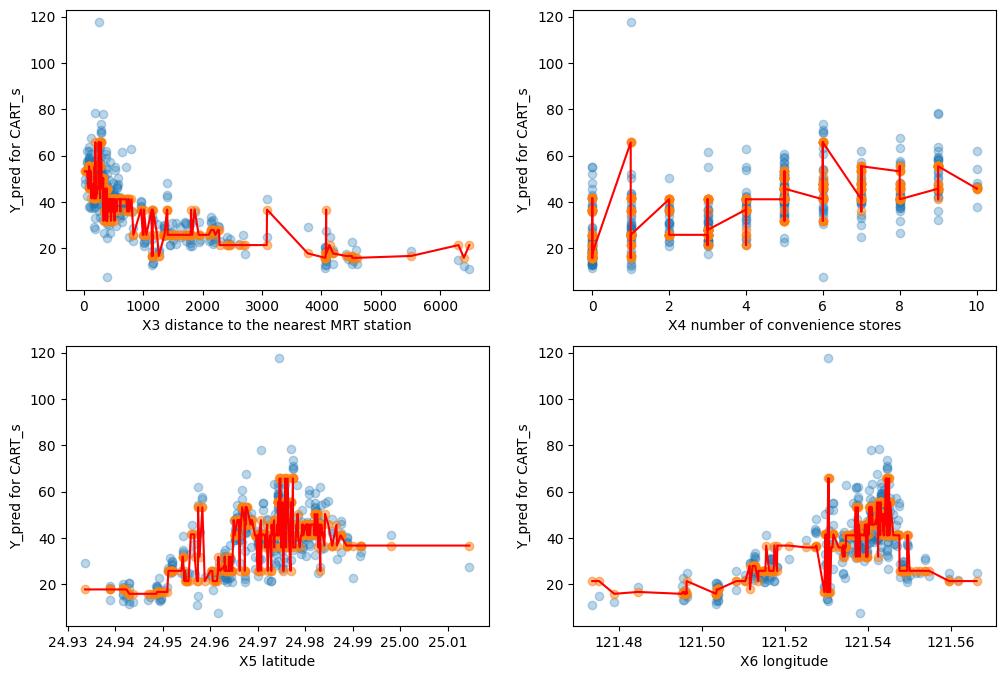

In [19]:
evaluate_model('CART_s', CART_model, X_train_s, Y_train_s, rows=2, cols=2)

#### Модель CART_ss - стандартизованный преобразованный набор (X3-X6)

RMSE for CART_ss: 0.5342680966227151
R^2 for CART_ss: 0.7392331390684903


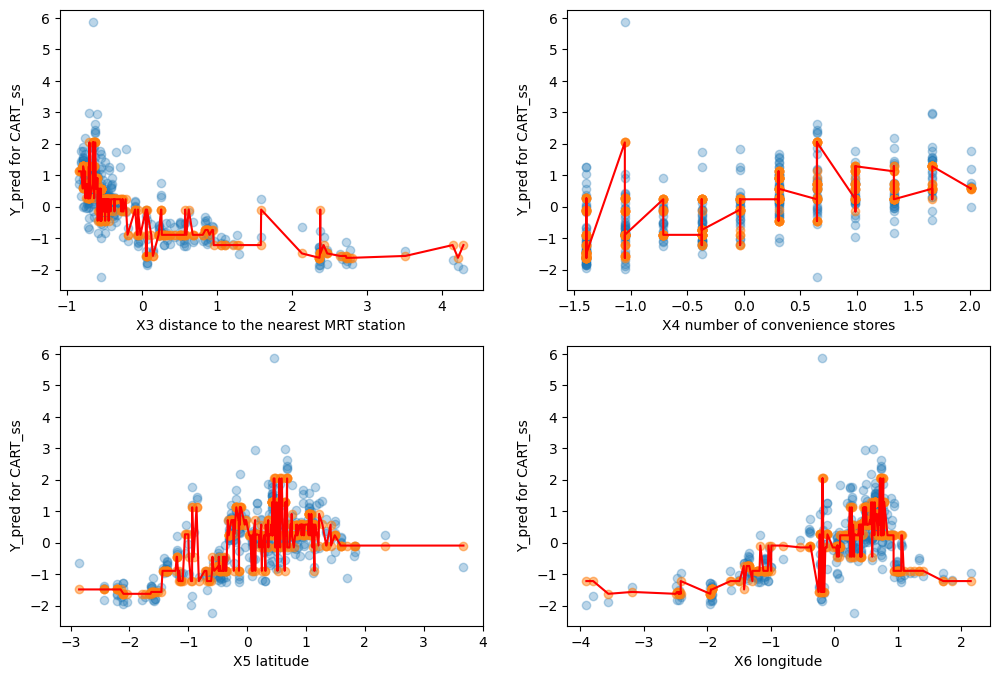

In [20]:
evaluate_model('CART_ss', CART_model, X_train_ss, Y_train_ss, rows=2, cols=2)

#### Модель RF_s (Random Forest) - нестандартизованный преобразованный набор (X3-X6)

RMSE for RF_s: 7.332753431463212
R^2 for RF_s: 0.7340338892256206


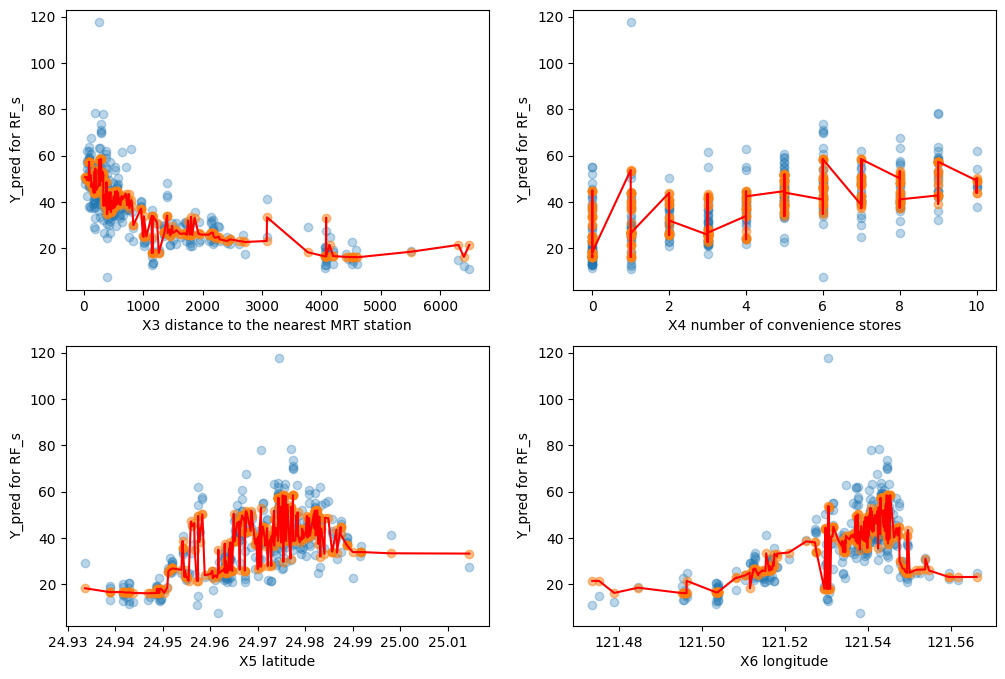

In [21]:
evaluate_model('RF_s', RF_model, X_train_s, Y_train_s, rows=2, cols=2)

#### Модель RF_ss (Random Forest) - стандартизованный преобразованный набор (X3-X6)

RMSE for RF_ss: 0.5395576842747414
R^2 for RF_ss: 0.7340440686924561


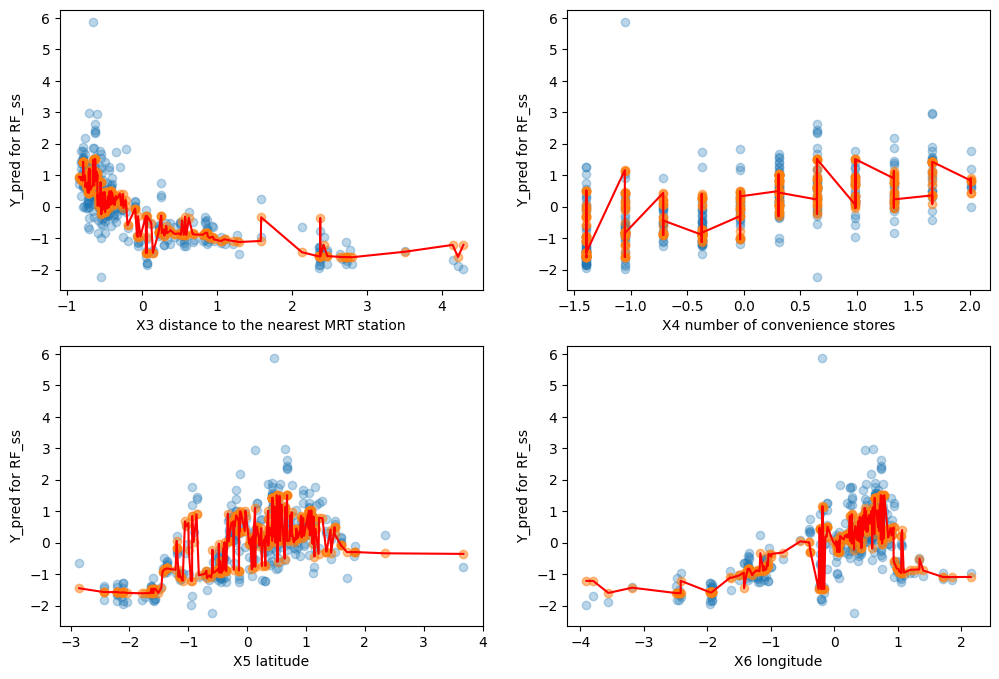

In [22]:
evaluate_model('RF_ss', RF_model, X_train_ss, Y_train_ss, rows=2, cols=2)

#### Модель CART_t - нестандартизованный преобразованный набор (X3)

RMSE for CART_t: 8.007694591634404
R^2 for CART_t: 0.6828190166848672


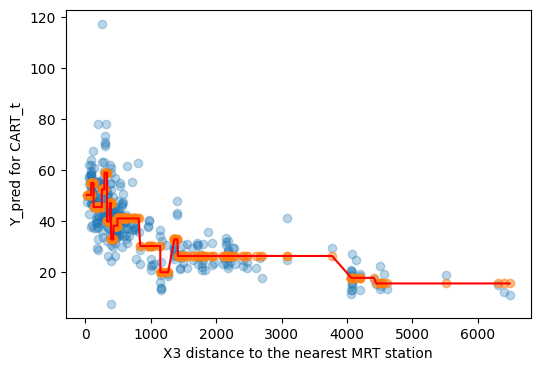

In [23]:
evaluate_model('CART_t', CART_model, X_train_t, Y_train_t)

#### Модель CART_st - стандартизованный преобразованный набор (X3)

RMSE for CART_st: 0.5892323907516679
R^2 for CART_st: 0.6828190166848671


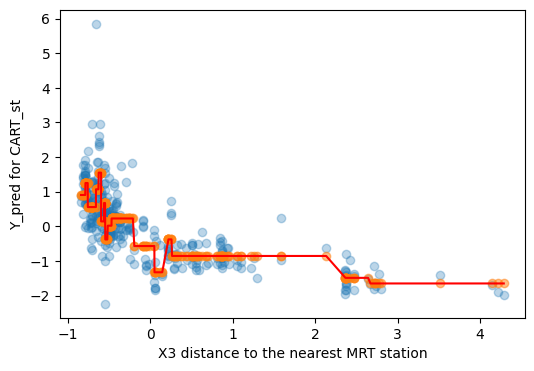

In [24]:
evaluate_model('CART_st', CART_model, X_train_st, Y_train_st)

#### Модель RF_t (Random Forest) - нестандартизованный преобразованный набор (X3)

RMSE for RF_t: 8.130966170137208
R^2 for RF_t: 0.6729783938007787


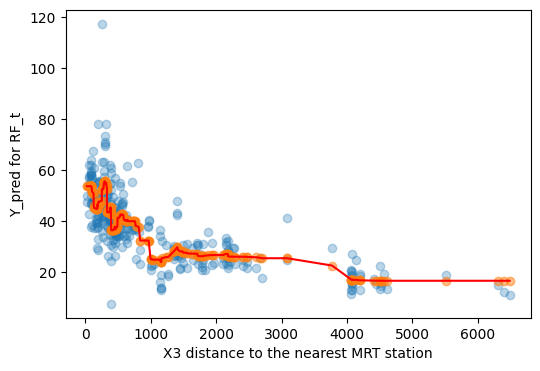

In [25]:
evaluate_model('RF_t', RF_model, X_train_t, Y_train_t)

#### Модель RF_st (Random Forest) - стандартизованный преобразованный набор (X3)

RMSE for RF_st: 0.5983031171738293
R^2 for RF_st: 0.6729783938007786


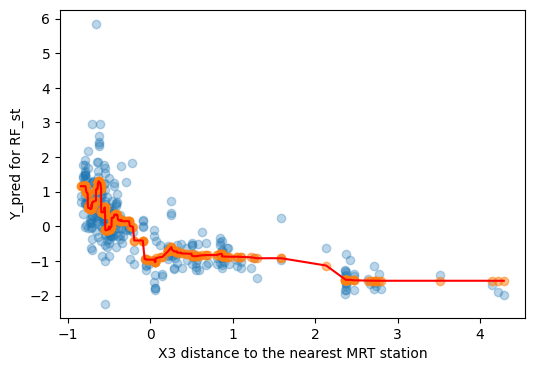

In [26]:
evaluate_model('RF_st', RF_model, X_train_st, Y_train_st)

#### Сравнительная таблица  

In [27]:
def print_quality():
    mq = model_quality
    mi = mq.index[mq['RMSE'].argmin()]
    ma =  mq.index[mq['R^2'].argmax()]
    print(f'min(RMSE) = {mi} = {mq["RMSE"][mi]:.6f}')
    print(f'max(R^2) = {ma} = {mq["R^2"][ma]:.6f}')

In [28]:
print_quality()
model_quality.T

min(RMSE) = CART_ss = 0.534268
max(R^2) = CART_s = 0.739233


,CART_f,CART_sf,RF_f,RF_sf,CART_s,CART_ss,RF_s,RF_ss,CART_t,CART_st,RF_t,RF_st
RMSE,7.486764,0.550901,7.277806,0.535543,7.260727,0.534268,7.332753,0.539558,8.007695,0.589232,8.130966,0.598303
R^2,0.722744,0.722744,0.738005,0.737987,0.739233,0.739233,0.734034,0.734044,0.682819,0.682819,0.672978,0.672978


В соответствии с полученными результатами, лучшей моделью является ```CART_ss``` (стандартизированный набор данных [X3-X6]) с параметрами минимального числа образцов в узле 10 (```min_samples_leaf=10```) и максимальной глубиной дерева 5 (```max_depth=5```). Для дальнейшего рассмотрения будет использована данная модель.

## Grid-поиск для CART-модели на обучающем стандартизированном наборе данных second (X3-X6)

In [29]:
model_quality.drop(model_quality.index, inplace=True)
arr_d = np.arange(2, 17, 2)
arr_s = np.arange(5, 21, 5)
for d in arr_d:
    for s in arr_s:
        CART_model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=25)
        evaluate_model(f'CART[d={d}, s={s}]', CART_model, X_train_ss, Y_train_ss, rows=2, cols=2, is_show_info=False)
print_quality()
model_quality

min(RMSE) = CART[d=10, s=5] = 0.465114
max(R^2) = CART[d=10, s=5] = 0.802370


,RMSE,R^2
"CART[d=2, s=5]",0.644855,0.620110
"CART[d=2, s=10]",0.644855,0.620110
"CART[d=2, s=15]",0.644855,0.620110
"CART[d=2, s=20]",0.644855,0.620110
"CART[d=4, s=5]",0.568020,0.705245
"CART[d=4, s=10]",0.557208,0.716359
"CART[d=4, s=15]",0.561305,0.712173
"CART[d=4, s=20]",0.573834,0.699180
"CART[d=6, s=5]",0.523581,0.749562
"CART[d=6, s=10]",0.526038,0.747205


На основе полученных результатов GRID-поиска можно сделать вывод, что лучшими параметрами для текущей модели на обучающей выборке являются ```max_depth=10``` и ```min_samples_leaf=5```.

## Grid-поиск для CART-модели на тестовом стандартизированном наборе данных second (X3-X6)

In [30]:
model_quality.drop(model_quality.index, inplace=True)
arr_d = np.arange(2, 17, 2)
arr_s = np.arange(5, 21, 5)
for d in arr_d:
    for s in arr_s:
        CART_model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=25)
        evaluate_model(f'CART[d={d}, s={s}]', CART_model, X_train_ss, Y_train_ss, X_test_ss, Y_test_ss, rows=2, cols=2, is_show_info=False)
print_quality()
model_quality

min(RMSE) = CART[d=6, s=15] = 0.545048
max(R^2) = CART[d=6, s=15] = 0.522846


,RMSE,R^2
"CART[d=2, s=5]",0.591960,0.437176
"CART[d=2, s=10]",0.591960,0.437176
"CART[d=2, s=15]",0.591960,0.437176
"CART[d=2, s=20]",0.591960,0.437176
"CART[d=4, s=5]",0.568239,0.481379
"CART[d=4, s=10]",0.566239,0.485023
"CART[d=4, s=15]",0.545221,0.522543
"CART[d=4, s=20]",0.546144,0.520926
"CART[d=6, s=5]",0.551259,0.511910
"CART[d=6, s=10]",0.567071,0.483508


На тестовой выборке лучшими параметрами для текущей модели являются ```max_depth=6``` и ```min_samples_leaf=15```.

## Сравнение с лучшей моделью из ЛР1

В ЛР1 лучшей моделью была Elastic Net на наборе данных second. Для обучающего набора лучшими параметрами были ```alpha=0.25``` и ```r=0.25```, а для тестового ```alpha=0.25``` и ```r=0.50```.

In [31]:
model_quality.drop(model_quality.index, inplace=True)
models = {
    'CART[d=10, s=5]': DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=25),
    'CART[d=6, s=15]': DecisionTreeRegressor(max_depth=6, min_samples_leaf=15, random_state=25),
    'EN[a=0.25, r=0.25]': ElasticNet(alpha=0.25, l1_ratio=0.25),
    'EN[a=0.25, r=0.50]': ElasticNet(alpha=0.25, l1_ratio=0.50)
}
for name in models:
    evaluate_model(name + ' (train)', models[name], X_train_ss, Y_train_ss, rows=2, cols=2, is_show_info=False)
    evaluate_model(name + ' (test) ', models[name], X_train_ss, Y_train_ss, X_test_ss, Y_test_ss, rows=2, cols=2, is_show_info=False)
print_quality()
model_quality

min(RMSE) = CART[d=10, s=5] (train) = 0.465114
max(R^2) = CART[d=10, s=5] (train) = 0.802370


,RMSE,R^2
"CART[d=10, s=5] (train)",0.465114,0.802370
"CART[d=10, s=5] (test)",0.563875,0.489314
"CART[d=6, s=15] (train)",0.553581,0.720039
"CART[d=6, s=15] (test)",0.545048,0.522846
"EN[a=0.25, r=0.25] (train)",0.730837,0.512050
"EN[a=0.25, r=0.25] (test)",0.552521,0.509674
"EN[a=0.25, r=0.50] (train)",0.741782,0.497326
"EN[a=0.25, r=0.50] (test)",0.547787,0.518039


Для обучающих данных лучшие показатели: ```CART[d=10, s=5]```.  
Для тестовых данных лучшие показатели: ```CART[d=6, s=15]```.  
Однако при переходе с обучающих на тестовые данные, видно снижение показателя R^2, что говорит о некоторой степени переобучения. Но все равно ```CART[d=6, s=15]``` для тестовых наборов чуть лучше, чем ```EN[a=0.25, r=0.50]``` (Elastic Net).

# Выводы:

В ходе выполнения работы был выполнен предиктивный анализ данных на основе древовидных стуктур.  
При рассмотрении использовались 3 пары набора данных: ```first (X1, X3-X6)```, ```second (X3-X6)``` и ```third (X3)``` [стандартизированных и нестандартизированных].  
Лучшеё моделью выбрана CART-модель при стандартизированном наборе second (RMSE=0.53, R^2=0.74).  
При выполнении Grid-поиска выделены следующие параметры:
- для обучающих данных: ```max_depth=10``` и ```min_samples_leaf=5``` (RMSE=0.47, R^2=0.80);
- для тестовых данных: ```max_depth=6``` и ```min_samples_leaf=15``` (RMSE=0.55, R^2=0.52).  

Данные показатели сравнивались с моделями из ЛР1: ```Elastic Net [a=0.25, r=0.25] (train)```  и ```Elastic Net [a=0.25, r=0.50] (test)``` .  
В обоих случаях CART-моедль показала лучший результат.